In [ ]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

100%|██████████| 350M/350M [00:16<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shanegerami/ai-vs-human-text/versions/1


In [ ]:
import os

for files in os.listdir(path):
  print(files)


AI_Human.csv


In [ ]:
import pandas as pd

for files in os.listdir(path):
  file_path = os.path.join(path,files)

df = pd.read_csv(file_path)
df.head(10)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
5,The electrol college system is an unfair syste...,0.0
6,"Dear state senator, It is the utmost respect t...",0.0
7,"Fellow citizens, cars have become a major role...",0.0
8,"""It's official: The electoral college is unfai...",0.0
9,The Electoral College has been kept for centur...,0.0


# Data Analysis

### 1- Data Overview and Initial Exploration

Detailed summary of the dataset

1- The columns present in the dataset.

2- The summary statistics you computed (for example, the count, mean, standard deviation, percentiles, etc., for the text length).

3- Any initial observations you made regarding the distribution of text lengths and the class balance.

In [ ]:
# 1- The columns present in the dataset.


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [ ]:
#2- The summary statistics you computed (for example, the count, mean, standard deviation, percentiles, etc., for the text length).

df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
#3- Any initial observations you made regarding the distribution of text lengths and the class balance.

df['generated'].value_counts()

,count
generated,
0.0,305797
1.0,181438


### 2: Analyzing Text Lengths

#### Compute the Text Lengths:

Create a new column in the DataFrame that contains the length of each text.

Provide summary statistics (count, mean, std, percentiles, etc.) for this new text_length column.

In [ ]:
df['text_length'] = df['text'].apply( lambda x : len(x.split(" ")))
df['text_length'].describe()

,text_length
count,487235.000000
mean,389.602178
std,174.837488
min,1.000000
25%,275.000000
50%,358.000000
75%,466.000000
max,14818.000000


#### Visualize the Distribution:

Plot a histogram or a box plot of the text_length to visualize its distribution.

Describe any key observations from these plots.
outliers, skewness, and the general range of text lengths.



<Axes: xlabel='text_length', ylabel='Count'>

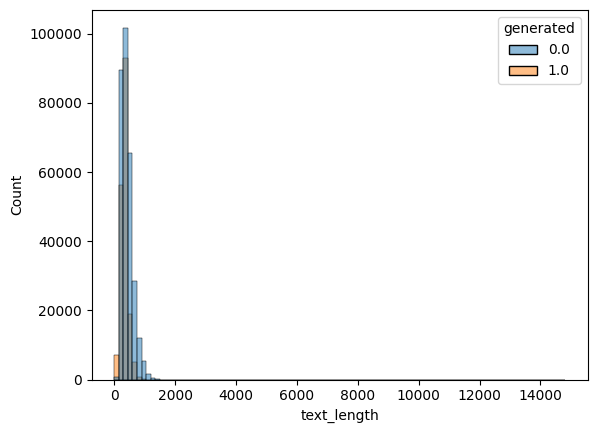

In [ ]:
import seaborn as sns
sns.histplot(data = df, x='text_length' , hue = 'generated', bins = 100)

In [ ]:
max_bin = 1500
bin_edges = list(range(0, max_bin + 150, 150)) + [float('inf')]
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-2)] + [f"{max_bin}+"]
# For example, bin_edges = [0, 100, 200, ..., 1500, float('inf')]
# bin_labels = ['0-99', '100-199', ..., '1400-1499', '1500+']

# Add the bins column to the dataframe
df['bins'] = pd.cut(df['text_length'], bins=bin_edges, labels=bin_labels, right=False)
df.head(3)

,text,generated,text_length,bins
0,Cars. Cars have been around since they became ...,0.0,581,450-599
1,Transportation is a large necessity in most co...,0.0,458,450-599
2,"""America's love affair with it's vehicles seem...",0.0,740,600-749


<Axes: xlabel='bins', ylabel='Count'>

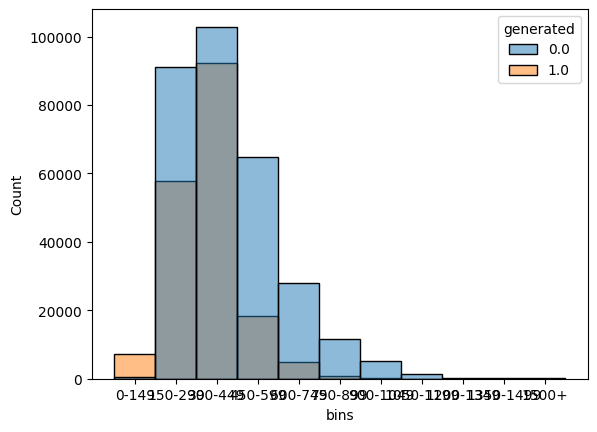

In [ ]:
sns.histplot(data = df, x='bins' , hue = 'generated')

In [ ]:
df1 = df[df['bins']=='1350-1499']
df1 ['generated'].value_counts()

,count
generated,
0.0,68


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
def dynamic_balance_bins(df, bin_col='bins', class_col='generated', seed=42):
    balanced_dfs = []

    # Ensure bins column is categorical
    if not pd.api.types.is_categorical_dtype(df[bin_col]):
        df[bin_col] = df[bin_col].astype('category')

    # Iterate over each bin
    for bin_value in df[bin_col].cat.categories:
        bin_df = df[df[bin_col] == bin_value]

        # Group by class and count records
        class_counts = bin_df[class_col].value_counts()

        # Skip bins with only one class
        if len(class_counts) < 2:
            continue

        # Find the minimum class count
        min_count = class_counts.min()

        # Downsample each class to the minimum count
        balanced_bin_df = bin_df.groupby(class_col, group_keys=False).apply(
            lambda x: x.sample(n=min_count, random_state=seed)
        )
        balanced_dfs.append(balanced_bin_df)

    # Combine balanced data
    if balanced_dfs:
        df_balanced = pd.concat(balanced_dfs)
    else:
        raise ValueError("No bins with multiple classes found.")

    # Remove unused categories
    df_balanced[bin_col] = df_balanced[bin_col].cat.remove_unused_categories()

    return df_balanced

# Apply the function
df_balanced = dynamic_balance_bins(df)

print(df_balanced.groupby('bins')['generated'].value_counts())

# Reduce dataset size (if needed)
dataset, _ = train_test_split(
    df_balanced, test_size=0.9, stratify=df_balanced['generated'], random_state=42
)

# Remove unused categories again
dataset['bins'] = dataset['bins'].cat.remove_unused_categories()

print(dataset['generated'].value_counts())
print(dataset['bins'].value_counts())

# Keep only necessary columns
dataset = dataset[['text', 'generated']]

# Single split into train, validation, and test sets
train_df, temp_df = train_test_split(
    dataset, test_size=0.30, stratify=dataset['generated'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['generated'], random_state=42
)

# Print dataset sizes
print(f"train_df shape: {train_df.shape}")
print(f"val_df shape: {val_df.shape}")
print(f"test_df shape: {test_df.shape}")

# Check class distributions
print("Train class distribution:\n", train_df['generated'].value_counts())
print("Validation class distribution:\n", val_df['generated'].value_counts())
print("Test class distribution:\n", test_df['generated'].value_counts())


<ipython-input-14-7330517fae78>:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[bin_col]):
<ipython-input-14-7330517fae78>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_bin_df = bin_df.groupby(class_col, group_keys=False).apply(
<ipython-input-14-7330517fae78>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

bins       generated
0-149      0.0            649
           1.0            649
150-299    0.0          57836
           1.0          57836
300-449    0.0          92343
           1.0          92343
450-599    0.0          18398
           1.0          18398
600-749    0.0           4775
           1.0           4775
750-899    0.0            731
           1.0            731
900-1049   0.0             85
           1.0             85
1050-1199  0.0             17
           1.0             17
1200-1349  0.0              1
           1.0              1
Name: count, dtype: int64
generated
1.0    17484
0.0    17483
Name: count, dtype: int64
bins
300-449      18395
150-299      11584
450-599       3725
600-749        972
750-899        140
0-149          129
900-1049        19
1050-1199        3
Name: count, dtype: int64
train_df shape: (24476, 2)
val_df shape: (5245, 2)
test_df shape: (5246, 2)
Train class distribution:
 generated
0.0    12238
1.0    12238
Name: count, dtype: int64
Val

<Axes: xlabel='bins', ylabel='Count'>

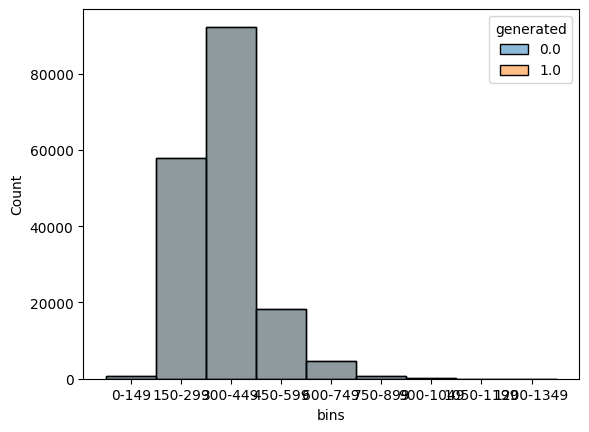

In [ ]:
sns.histplot(data = df_balanced, x='bins' , hue = 'generated')

In [ ]:
# making a dataset with the neccessary data

dataset = dataset[['text', 'generated']]
print(dataset.shape)
dataset.head(5)

(34967, 2)


,text,generated
91484,Many children today are faced with the decisio...,1.0
145874,"Hear Florida's Senator,\n\nI disagree with the...",0.0
435392,The Opportunity to Graduate Early: benefits a...,1.0
353439,As the world becomes more accessible and affor...,1.0
356966,Online classes are becoming increasingly popul...,1.0


In [ ]:
from sklearn.model_selection import train_test_split

_,sample_dataset = train_test_split(dataset, test_size = 0.20 , random_state= 42, stratify=dataset['generated'])

train_df, val_set = train_test_split(sample_dataset, test_size = 0.30, random_state = 42, stratify = sample_dataset['generated'])

val_df, test_df = train_test_split(val_set, test_size = 0.5 , random_state= 42, stratify = val_set['generated'])

print(f" train_df shape: {train_df.shape}" )
print(f" test_df shape: {test_df.shape}" )
print(f" val_df shape: {val_df.shape}" )

 train_df shape: (4895, 2)
 test_df shape: (1050, 2)
 val_df shape: (1049, 2)


## Creat a Pytorch Dataset Class

In [ ]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import torch

class HumanAiDataset(Dataset):
    def __init__(self, dataset, tokenizer, text_column, target_column, max_token_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.target_column = target_column
        self.max_token_length = max_token_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        item = self.dataset.iloc[index]
        text = str(item[self.text_column])
        labels = torch.tensor(item[self.target_column], dtype=torch.long)

        tokens = self.tokenizer.encode_plus(
            text,
            return_tensors='pt',
            return_attention_mask=True,
            add_special_tokens=True,
            max_length=self.max_token_length,
            padding='max_length',
            truncation=True
        )

        return {'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'labels' : labels }

# Initialize tokenizer and dataset
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

data_set = HumanAiDataset(
    dataset=dataset,
    tokenizer=tokenizer,
    text_column='text',
    target_column='generated',
    max_token_length=512
)

print("Number of samples:", len(data_set))
print(data_set[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Number of samples: 34967
{'input_ids': tensor([  101,  2116,  2336,  2651,  2024,  4320,  2007,  1996,  3247,  1997,
         2054,  2027,  2323,  2079,  2044,  2082,  1012,  2096,  2070, 23569,
         2000,  2994,  2188,  1998,  9483,  1010,  2500,  2089,  5770,  2013,
         8019,  1999,  4114,  3450,  1012,  5378,  2402,  2111,  1037,  3528,
         1997,  3450,  2000,  8849,  2064,  4372, 13149,  2037,  3268,  1998,
         3073,  1999, 10175,  6692,  3468,  4813,  1998,  6322,  1012, 11973,
         1999,  3450,  2044,  2082,  2064,  6570,  2336,  2147,  3802, 16066,
         1010, 13296,  4813,  1010,  5368,  1010,  1998,  9009,  1012,  2083,
         4114,  3450,  1010, 25947,  2468,  2062,  2981,  1998,  4503,  3247,
         2437,  4813,  1012,  2027,  4553,  2000,  6133,  2037,  2051,  1998,
         3188, 25090,  4371,  8518,  1998,  3450,  1012,  1999,  2804,  1010,
         8019,  1999,  3450, 12011,  4268,  2129,  2000,  2147,  1998, 17654,
         2007,  2060,  21

In [ ]:
%%capture
! pip install pytorch_lightning



  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached torchmetrics-1.6.2-py3-none-any.whl.metadata (20 kB)
  Using cached lightning_utilities-0.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)


## PyTorch Lightning DataModule

In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

2.5.0.post0


In [ ]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class HumanAiDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, val_df, text_column, target_column=None, config=None):
        super().__init__()
        self.config = config or {}
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.text_column = text_column
        self.target_column = target_column
        self.batch_size = self.config['batch_size']
        self.max_token_length = self.config['max_token_length']
        self.model_name = self.config['model_name']
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

    def setup(self, stage=None):
        if stage in [None, 'fit']:
            self.train_dataset = HumanAiDataset(self.train_df, self.tokenizer, self.text_column, self.target_column, self.max_token_length)
            self.val_dataset = HumanAiDataset(self.val_df, self.tokenizer, self.text_column, self.target_column, self.max_token_length)

        if stage == 'predict':
            self.test_dataset = HumanAiDataset(self.test_df, self.tokenizer, self.text_column, None, self.max_token_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_df, batch_size=self.batch_size, num_workers=4, shuffle=False)

# Configuration
config = {
    'batch_size': 16,
    'max_token_length': 512,
    'model_name': 'distilbert-base-uncased'
}

data_module = HumanAiDataModule(train_df, val_df, test_df, text_column='text', target_column='generated', config=config)



## PyTorch Lightning Model

In [ ]:
from transformers import AutoModel, get_cosine_schedule_with_warmup
import torch.nn.functional as F
import math
from torch import nn

class HumanAiModelModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.pretrained_model = AutoModel.from_pretrained(self.config['model_name'], return_dict=True)
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, 1)

        nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss()
        self.dropout = nn.Dropout()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_out = torch.mean(output.last_hidden_state, dim=1)
        pooled_out = self.dropout(pooled_out)
        pooled_out = self.hidden(pooled_out)
        pooled_out = F.relu(pooled_out)
        pooled_out = self.dropout(pooled_out)
        logits = self.classifier(pooled_out).view(-1)

        loss = self.loss_func(logits, labels.float()) if labels is not None else 0
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, outputs = self(**batch)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, outputs = self(**batch)
        self.log('validation_loss', loss, prog_bar=True, logger=True)
        return loss

    def predict_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = (self.config['train_size'] / self.config['batch_size'])
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]



In [ ]:
config = {
    'model_name': 'distilbert-base-uncased',
    'batch_size': 16,
    'max_token_length': 512,
    'n_labels': 2,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'weight_decay': 0.001,
    'n_epochs': 8
}

humanai_datamodule = HumanAiDataModule(
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    text_column = 'text',
    target_column = 'generated',
    config = config
)

humanai_datamodule.setup()
config['train_size'] = len(humanai_datamodule.train_dataloader())

model = HumanAiModelModule(config)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# datamodule
humanai_datamodule = HumanAiDataModule(
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    text_column = 'text',
    target_column = 'generated',
    config = config
)
humanai_datamodule.setup()
config['train_size'] = len(humanai_datamodule.train_dataloader())

# model
model = HumanAiModelModule(config)

# trainer and fit
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    devices=1 if torch.cuda.is_available() else 0,  # Uncomment if needed
    # accelerator='gpu' if torch.cuda.is_available() else 'cpu',  # Uncomment if needed
    num_sanity_val_steps=2
)

# Start training
trainer.fit(model, datamodule=humanai_datamodule)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | DistilBertModel   | 66.4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

Launching TensorBoard...

## Training & Evaluation

In [ ]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
import numpy as np
predictions = classify_raw_comments(model, humanai_datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
val_data = val_df
true_labels = np.array(val_data['generated'])


In [ ]:
import matplotlib.pyplot as plt


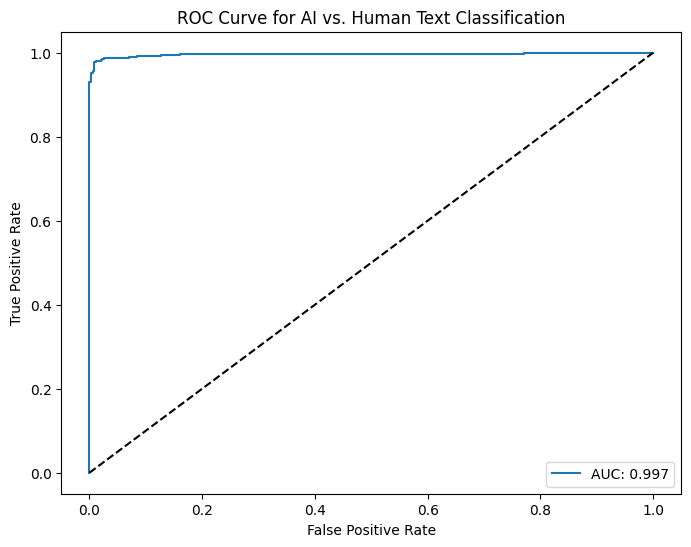

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Convert predictions to numpy array if needed
predictions = np.array(predictions).flatten()

# Ensure labels are in the correct shape
true_labels = np.array(val_df['generated']).astype(int)

# Compute ROC curve and AUC
fpr, tpr, _ = metrics.roc_curve(true_labels, predictions)
auc = metrics.roc_auc_score(true_labels, predictions)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AI vs. Human Text Classification')
plt.legend(loc='lower right')
plt.show()
